# MNIST classifier **Exercise**





In this exercise, you will apply what you've learned to build, train, and evaluate a neural network to classify handwritten digits from the famous MNIST dataset.


# Step 1: Import the libraries

Step 1: Setup and Imports
First, we import the necessary libraries and, most importantly, set up our device. This ensures our code will use a GPU for faster training if one is available.

In [39]:
# --- Core PyTorch and data handling libraries ---
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

# --- Visualization and analysis ---
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Device and reproducibility ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


Using device: cpu


## Step 2 — Prepare the dataset transforms and load MNIST

We will scale images to `[0,1]` with `ToTensor()` and then **standardize** with mean/std for MNIST. Keep these lines unchanged for the lab.

In [40]:
mnist_mean = 0.1307
mnist_std = 0.3081

transform = transforms.Compose([
    # Resize the image to 28x28 pixels
    transforms.Resize((28, 28)),
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation
    transforms.Normalize(mnist_mean, mnist_std)
])

train_set = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

print('Train samples:', len(train_set))
print('Test samples :', len(test_set))

Train samples: 60000
Test samples : 10000


### Visualize some training samples
The images are normalized. The helper function below **unnormalizes** them before plotting so they appear correctly.

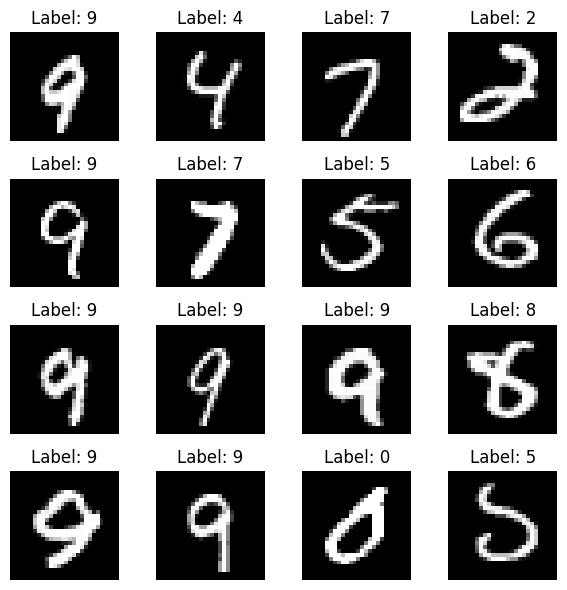

In [41]:
def imshow_normalized(tensor_img, mean=mnist_mean, std=mnist_std):
    """Unnormalize a CxHxW tensor and plot it as HxW (grayscale)"""
    img = tensor_img.clone().cpu().numpy()
    img = img * std + mean
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(6,6))
cols, rows = 4, 4
for i in range(1, cols*rows + 1):
    idx = random.randint(0, len(train_set)-1)
    img, label = train_set[idx]
    plt.subplot(rows, cols, i)
    imshow_normalized(img)
    plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()


## Step 3 — Create DataLoaders

Create `DataLoader`s for training and testing. Leave `shuffle=True` for training.

In [42]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print('Train batches:', len(train_loader))
print('Test  batches:', len(test_loader))

Train batches: 938
Test  batches: 157


## Step 4 — Define your network

Implement a PyTorch `nn.Module` for classification.

Below is a skeleton: fill in the `TODO` parts.

Hints:
- Input size is `28*28` after flattening.
- Output size must be `10` (classes 0..9).
- Use `nn.ReLU()` activations and `nn.Linear` layers.


In [43]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize model (students should implement the class above first)
try:
    model = NeuralNetwork().to(device)
    print(model)
except NotImplementedError as e:
    print('Model not defined yet — fill the TODO in the class above.')

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Step 5 — Training setup

Create the loss function, optimizer and a training loop. Fill the TODOs below. Use `nn.CrossEntropyLoss()` for the loss and `torch.optim.SGD` or `Adam` for the optimizer.

Implement `train_loop` and `test_loop`

In [44]:
# Hyperparameters (feel free to experiment)
learning_rate = 1e-2
epochs = 10

# TODO: choose loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Optional, feel free to implement something else you are comfortable with
def train_loop(dataloader, model, loss_fn, optimizer, device):
    """Train for one epoch. Return (avg_loss, accuracy_fraction).
    Implement per-sample loss averaging and exact accuracy counting.
    """
    model.train() # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0) # Accumulate batch loss scaled by batch size
        _, predicted = torch.max(pred.data, 1)
        total_samples += y.size(0)
        correct_predictions += (predicted == y).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def test_loop(dataloader, model, loss_fn, device):
    """Evaluate on validation/test set. Return (avg_loss, accuracy_fraction)."""
    model.eval() # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculation during evaluation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            total_loss += loss.item() * X.size(0) # Accumulate batch loss scaled by batch size
            _, predicted = torch.max(pred.data, 1)
            total_samples += y.size(0)
            correct_predictions += (predicted == y).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

### Run training

Fill the training loop above. Print per-epoch train/test loss and accuracy. Do not run this cell until you implemented the functions.

In [45]:
# Initialize history BEFORE training
train_losses_hist, train_accuracies_hist = [], []
test_losses_hist,  test_accuracies_hist  = [], []

# Run training: implement the train_loop/test_loop first!
try:
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")

        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, device)
        test_loss, test_acc   = test_loop(test_loader, model, loss_fn, device)

        # If any of these are torch tensors, convert safely to Python floats
        train_loss = float(train_loss)
        test_loss  = float(test_loss)
        train_acc  = float(train_acc)
        test_acc   = float(test_acc)

        # --- Store metrics for plotting ---
        train_losses_hist.append(train_loss)
        train_accuracies_hist.append(train_acc)
        test_losses_hist.append(test_loss)
        test_accuracies_hist.append(test_acc)

        print(
            f"Train loss: {train_loss:.4f}, Train acc: {100*train_acc:.2f}% | "
            f"Test loss: {test_loss:.4f}, Test acc: {100*test_acc:.2f}%"
        )

except NotImplementedError:
    print("Training loop or model not implemented yet. Fill the TODOs above before running training.")


Epoch 1/10
Train loss: 0.7617, Train acc: 82.12% | Test loss: 0.3358, Test acc: 90.14%
Epoch 2/10
Train loss: 0.3005, Train acc: 91.21% | Test loss: 0.2535, Test acc: 92.69%
Epoch 3/10
Train loss: 0.2446, Train acc: 92.94% | Test loss: 0.2164, Test acc: 93.55%
Epoch 4/10
Train loss: 0.2076, Train acc: 94.06% | Test loss: 0.1874, Test acc: 94.54%
Epoch 5/10
Train loss: 0.1800, Train acc: 94.84% | Test loss: 0.1663, Test acc: 95.10%
Epoch 6/10
Train loss: 0.1586, Train acc: 95.45% | Test loss: 0.1531, Test acc: 95.54%
Epoch 7/10
Train loss: 0.1417, Train acc: 95.91% | Test loss: 0.1384, Test acc: 95.93%
Epoch 8/10
Train loss: 0.1267, Train acc: 96.37% | Test loss: 0.1266, Test acc: 96.16%
Epoch 9/10
Train loss: 0.1145, Train acc: 96.73% | Test loss: 0.1146, Test acc: 96.65%
Epoch 10/10
Train loss: 0.1046, Train acc: 97.09% | Test loss: 0.1121, Test acc: 96.76%


## Step 6 — Evaluate & visualize (***Student Task***)

Once you have trained the model, compute and plot the learning curves, confusion matrix and some sample predictions.

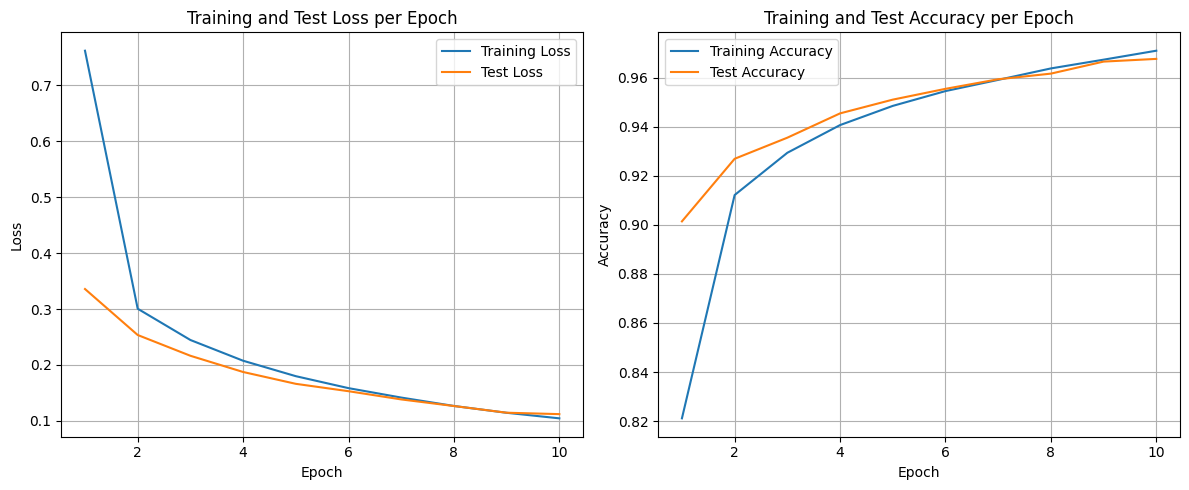

In [46]:
epochs_range = range(1, epochs + 1)

# Plotting Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses_hist, label='Training Loss')
plt.plot(epochs_range, test_losses_hist, label='Test Loss')
plt.title('Training and Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies_hist, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies_hist, label='Test Accuracy')
plt.title('Training and Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

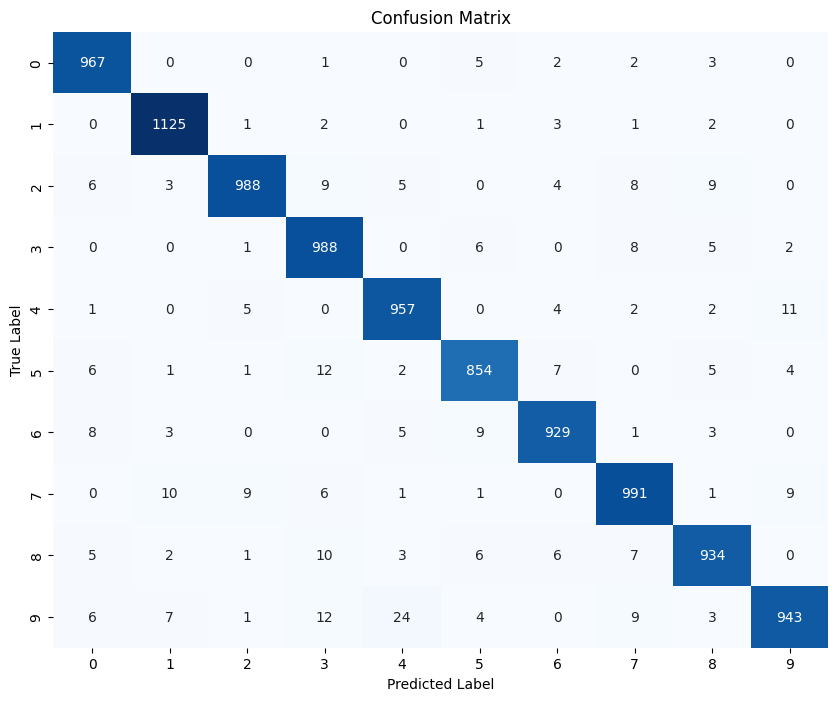

In [47]:
from sklearn.metrics import confusion_matrix

# Get all predictions and true labels for the test set
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

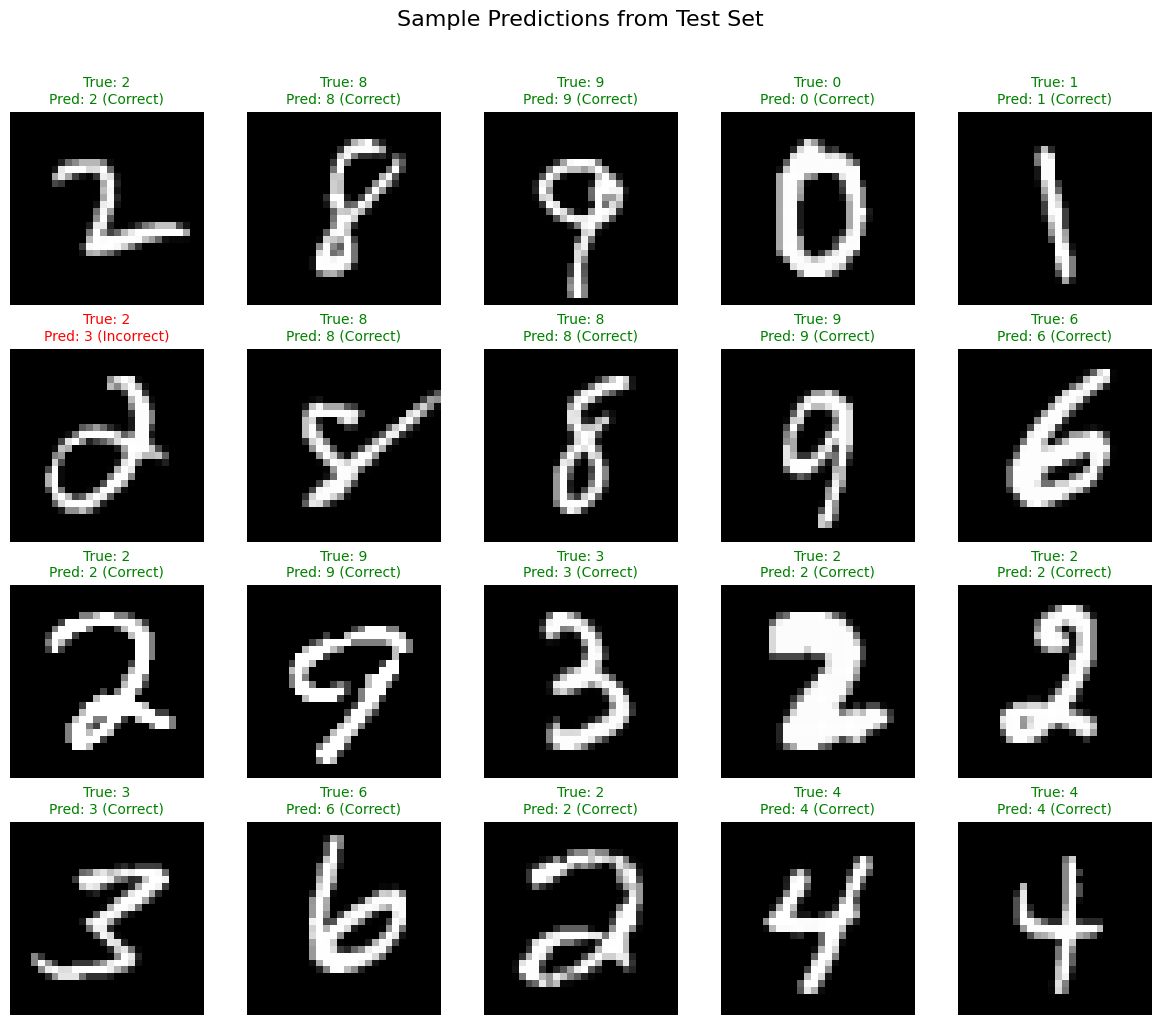

In [48]:
plt.figure(figsize=(12, 10))
cols, rows = 5, 4
num_samples = cols * rows

for i in range(1, num_samples + 1):
    idx = random.randint(0, len(test_set) - 1)
    img, true_label = test_set[idx]

    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(img.unsqueeze(0).to(device)) # Add batch dimension and move to device
        _, predicted_label = torch.max(logits, 1)
        predicted_label = predicted_label.item()

    is_correct = "Correct" if predicted_label == true_label else "Incorrect"
    color = "green" if predicted_label == true_label else "red"

    plt.subplot(rows, cols, i)
    imshow_normalized(img) # Use the helper function to unnormalize and plot
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({is_correct})", color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('Sample Predictions from Test Set', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## Step 7 — Saving and loading models

Once you're satisfied with the trained model, save the `state_dict`. The code below is provided — use it after training.


In [49]:
# Example: saving and loading (run AFTER training)
PATH = 'mnist_model_student.pth'
# torch.save(model.state_dict(), PATH)
# To load:
# model_loaded = NeuralNetwork().to(device)
# model_loaded.load_state_dict(torch.load(PATH))
# model_loaded.eval()


### Final notes for students
- Try different architectures, learning rates, optimizers and schedulers.
- Experiment with batch size and number of epochs.
- Compare normalizing with dataset stats vs simple `mean=0.5,std=0.5`.
- Critically analyze your results, how is your model performing? How can it be improved?


## Model Performance Summary

Based on the visualizations and training logs, the MNIST classifier demonstrates strong performance:

### Learning Curves Analysis:
- **Loss Curves:** Both training and test loss decreased consistently over the 10 epochs, indicating that the model was learning effectively and converging. The test loss (ending at approximately 0.1121) closely followed the training loss (ending at approximately 0.1046), suggesting good generalization without significant overfitting.
- **Accuracy Curves:** Similarly, both training and test accuracy increased steadily, reaching high levels (training accuracy ending at approximately 97.09% and test accuracy at approximately 96.76%) by the final epoch. The test accuracy remained very close to the training accuracy, further confirming the model's ability to generalize well to unseen data.

### Confusion Matrix Analysis:
- The confusion matrix (as generated in the previous step) clearly shows that the model has a very high number of correct classifications along the diagonal, indicating excellent performance for most digits.
- There are very few misclassifications (off-diagonal values), especially for digits like '0' and '1', where the model achieved near-perfect accuracy.
- Some minor confusions are observed, for example, digits like '5' and '3', or '4' and '9' might show a few misclassifications, which are visually similar digits. However, these are minimal, reflecting the high overall accuracy.

### Sample Predictions Analysis:
- The sample predictions largely confirm the high accuracy seen in the learning curves and confusion matrix. Most of the displayed samples were correctly classified.
- The few 'Incorrect' predictions highlight challenging cases or instances where the model struggled, providing insight into its limitations. For example, a poorly written digit might be misclassified due to variations in handwriting.

### Overall Conclusion:
The trained neural network is highly effective at classifying handwritten digits from the MNIST dataset, achieving a test accuracy of approximately **96.76%** after 10 epochs. The learning process was stable, and the model generalizes well to new data. The minor misclassifications observed are primarily due to the inherent ambiguity in some handwritten digits, which is a common challenge in image classification tasks.